# Analysis Seoul Crime 

> 서울시 범죄 현황에 관련된 데이터 전처리, 시각화 토이 프로젝트입니다.   
> 데이터가 적어 분석결과의 신뢰도는 낮다는 점을 인지해주시기 바랍니다.

## 1. 데이터 읽기

In [107]:
# 모듈 불러오기

import numpy as np 
import pandas as pd 
import googlemaps

import json
import folium

import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rc

plt.rcParams["axes.unicode_minus"] = False 
get_ipython().run_line_magic("matplotlib", "inline")
rc("font", family="Malgun Gothic")

In [108]:
# 데이터 읽기 
raw_data = pd.read_csv("../data/02. crime_in_Seoul.csv", thousands=",", encoding="euc-kr") # thousands 숫자값을 문자로 인식할 수 있어서 설정
raw_data.head()

,구분,죄종,발생검거,건수
0,중부,살인,발생,2.0
1,중부,살인,검거,2.0
2,중부,강도,발생,3.0
3,중부,강도,검거,3.0
4,중부,강간,발생,141.0


In [109]:
# RangeIndex가 665,534인데 non-null이 310밖에 없음을 확인할 수 있다.
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65534 entries, 0 to 65533
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   구분      310 non-null    object 
 1   죄종      310 non-null    object 
 2   발생검거    310 non-null    object 
 3   건수      310 non-null    float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [110]:
# nan데이터를 처리해야 된다
raw_data.tail()

,구분,죄종,발생검거,건수
65529,NaN,NaN,NaN,NaN
65530,NaN,NaN,NaN,NaN
65531,NaN,NaN,NaN,NaN
65532,NaN,NaN,NaN,NaN
65533,NaN,NaN,NaN,NaN


In [111]:
# df[df[열이름].isnull()] : 해당열에 null인 데이터
# df[df[열이름].notnull()] : 해당열에 null이 아닌 데이터

raw_data = raw_data[raw_data["죄종"].notnull()]

In [112]:
# 불필요한 데이터를 걷어내 용량이 가벼워졌음을 알 수 있다
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   구분      310 non-null    object 
 1   죄종      310 non-null    object 
 2   발생검거    310 non-null    object 
 3   건수      310 non-null    float64
dtypes: float64(1), object(3)
memory usage: 12.1+ KB


---

## 2. 서울시 범죄 현황 raw 데이터 전처리

In [113]:
raw_data.head()

,구분,죄종,발생검거,건수
0,중부,살인,발생,2.0
1,중부,살인,검거,2.0
2,중부,강도,발생,3.0
3,중부,강도,검거,3.0
4,중부,강간,발생,141.0


In [114]:
# 피벗테이블 활용

crime_station = raw_data.pivot_table(
    raw_data, 
    index="구분", 
    columns=["죄종", "발생검거"], 
    aggfunc=[np.sum])
crime_station.head()

sum                                                              
         건수                                                              
죄종       강간           강도          살인           절도              폭력        
발생검거     검거     발생    검거    발생    검거   발생      검거      발생      검거      발생
구분                                                                       
강남    269.0  339.0  26.0  24.0   3.0  3.0  1129.0  2438.0  2096.0  2336.0
강동    152.0  160.0  13.0  14.0   5.0  4.0   902.0  1754.0  2201.0  2530.0
강북    159.0  217.0   4.0   5.0   6.0  7.0   672.0  1222.0  2482.0  2778.0
강서    239.0  275.0  10.0  10.0  10.0  9.0  1070.0  1952.0  2768.0  3204.0
관악    264.0  322.0  10.0  12.0   7.0  6.0   937.0  2103.0  2707.0  3235.0

In [115]:
# 다중 컬럼
crime_station.columns

MultiIndex([('sum', '건수', '강간', '검거'),
            ('sum', '건수', '강간', '발생'),
            ('sum', '건수', '강도', '검거'),
            ('sum', '건수', '강도', '발생'),
            ('sum', '건수', '살인', '검거'),
            ('sum', '건수', '살인', '발생'),
            ('sum', '건수', '절도', '검거'),
            ('sum', '건수', '절도', '발생'),
            ('sum', '건수', '폭력', '검거'),
            ('sum', '건수', '폭력', '발생')],
           names=[None, None, '죄종', '발생검거'])

In [116]:
# 다중 컬럼에서 특정 컬럼 제거

crime_station.columns = crime_station.columns.droplevel([0,1]) 
crime_station.columns

MultiIndex([('강간', '검거'),
            ('강간', '발생'),
            ('강도', '검거'),
            ('강도', '발생'),
            ('살인', '검거'),
            ('살인', '발생'),
            ('절도', '검거'),
            ('절도', '발생'),
            ('폭력', '검거'),
            ('폭력', '발생')],
           names=['죄종', '발생검거'])

In [117]:
crime_station.head()

죄종       강간           강도          살인           절도              폭력        
발생검거     검거     발생    검거    발생    검거   발생      검거      발생      검거      발생
구분                                                                       
강남    269.0  339.0  26.0  24.0   3.0  3.0  1129.0  2438.0  2096.0  2336.0
강동    152.0  160.0  13.0  14.0   5.0  4.0   902.0  1754.0  2201.0  2530.0
강북    159.0  217.0   4.0   5.0   6.0  7.0   672.0  1222.0  2482.0  2778.0
강서    239.0  275.0  10.0  10.0  10.0  9.0  1070.0  1952.0  2768.0  3204.0
관악    264.0  322.0  10.0  12.0   7.0  6.0   937.0  2103.0  2707.0  3235.0

In [118]:
crime_station.columns.get_level_values(0)

Index(['강간', '강간', '강도', '강도', '살인', '살인', '절도', '절도', '폭력', '폭력'], dtype='object', name='죄종')

In [119]:
# 멀티 컬럼 정리 (with 리스트 내포)
new_column = [ 
    crime_station.columns.get_level_values(0)[n] + crime_station.columns.get_level_values(1)[n]
    for n in range(0, len(crime_station.columns.get_level_values(0)))
]
new_column

['강간검거',
 '강간발생',
 '강도검거',
 '강도발생',
 '살인검거',
 '살인발생',
 '절도검거',
 '절도발생',
 '폭력검거',
 '폭력발생']

In [120]:
# 새로운 컬럼 데이터 적용

crime_station.columns = new_column

In [121]:
crime_station.head()

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구분,,,,,,,,,,
강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0
강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0
강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0
강서,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0
관악,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0


In [122]:
# Google Maps API를 이용한 데이터 정리
# 구글 클라우드 플랫폼에서 개인 계정 구글 맵스 API를 복사 후 사용

gmaps_key = "개인계정 API"
gmaps = googlemaps.Client(key=gmaps_key)

In [123]:
# 현재 필요한 '구별', '위도', '경도' 컬럼을 추가하고 데이터를 NaN값으로 채움
# 이제 이 NaN값을 채울 방법을 찾아야 한다

crime_station["구별"] = np.nan
crime_station["위도"] = np.nan
crime_station["경도"] = np.nan

In [124]:
crime_station.head()

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,위도,경도
구분,,,,,,,,,,,,,
강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,NaN,NaN,NaN
강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,NaN,NaN,NaN
강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,NaN,NaN,NaN
강서,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0,NaN,NaN,NaN
관악,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0,NaN,NaN,NaN


In [125]:
# 총 31개의 데이터가 처리되어야 함
len(crime_station.index)

31

In [126]:
# 하지만 현재 서울종암경찰서가 데이터가 누락됨
# 예외는 따로 데이터를 입력해둘 것
gmaps.geocode("서울종암경찰서", language="ko")

[]

In [134]:
# 반복문을 통해 NaN값을 새로운 값으로 할당
# 반복문 사용시 서울종암경찰서에서 발생하는 오류를 피하기 위해 try / except 구문 사용
# 데이터가 잘 채워지고 있는지 count를 출력하여 확인 (오류 제외 30개가 성공되어야 함)

count = 0

for idx, rows in crime_station.iterrows():
    try:
        # NaN에 들어갈 데이터 : 구이름, 위도, 경도
        
        # 구이름 생성
        ## 구글에서 정확히 검색할 수 있도록 경찰서명을 생성
        search = "서울" + str(idx) + "경찰서"
        geo_datas = gmaps.geocode(search, language="ko")
        gu_names = geo_datas[0].get("formatted_address")

        # 위도, 경도 데이터 생성
        # print(geo_datas[0].get("geometry")["location"]["lat"])
        lat = geo_datas[0]["geometry"]["location"]["lat"]
        lng = geo_datas[0]["geometry"]["location"]["lng"]
               
        # NaN 값에 생성한 데이터를 할당
        # df.at 대신 df.loc을 사용하는 것도 가능함
        crime_station.at[idx, "구별"] = gu_names.split()[2]
        crime_station.at[idx, "위도"] = lat 
        crime_station.at[idx, "경도"] = lng
        
        count = count + 1
        print(count)
  
    except:
        police = "서울" + str(idx) + "경찰서"
        print(f'{police} 데이터를 불러오는 데 오류가 발생했습니다')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
서울종암경찰서 데이터를 불러오는 데 오류가 발생했습니다
28
29
30


In [135]:
# 오류가 발생한 서울종암경찰서의 데이터는 직접 할당함

crime_station.loc['종암', "구별"] = '종암구'
crime_station.loc['종암', '위도'] = 37.601990
crime_station.loc['종암', '경도'] = 127.032643

In [136]:
crime_station.head(3)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,위도,경도
구분,,,,,,,,,,,,,
강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,강남구,37.509435,127.066958
강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,강동구,37.528511,127.126822
강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,강북구,37.637304,127.027340


In [137]:
# 데이터 저장
crime_station.to_csv("../data/02. crime_in_Seoul_raw.csv", sep=",", encoding="utf-8")

In [138]:
pd.read_csv("../data/02. crime_in_Seoul_raw.csv").head(2)

,구분,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,위도,경도
0,강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,강남구,37.509435,127.066958
1,강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,강동구,37.528511,127.126822


---

## 3. 구별 데이터로 정리

In [168]:
crime_gu = pd.read_csv(
    "../data/02. crime_in_Seoul_raw.csv", index_col=0, encoding="utf-8") # index_col "구분"을 인덱스 컬럼으로 설정
crime_gu.head()

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,위도,경도
구분,,,,,,,,,,,,,
강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,강남구,37.509435,127.066958
강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,강동구,37.528511,127.126822
강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,강북구,37.637304,127.027340
강서,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0,강서구,37.551284,126.850038
관악,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0,관악구,37.474395,126.951349


In [169]:
# 구별 컬럼을 기준으로 피봇테이블
crime_gu = pd.pivot_table(crime_gu, index="구별", aggfunc=np.sum)

del crime_gu["위도"]
crime_gu.drop("경도", axis=1, inplace=True)

crime_gu.head()

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구별,,,,,,,,,,
강남구,413.0,516.0,42.0,39.0,5.0,5.0,1918.0,3587.0,3527.0,4002.0
강동구,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0
강북구,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0
강서구,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0
관악구,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0


In [170]:
# 검거율 컬럼 생성

crime_catch = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율"]
catch = ["강간검거", "강도검거", "살인검거", "절도검거", "폭력검거"]
crime = ["강간발생", "강도발생", "살인발생", "절도발생", "폭력발생"]

crime_gu[crime_catch] = crime_gu[catch].div(crime_gu[crime].values) * 100 
crime_gu.head()

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,,,
강남구,413.0,516.0,42.0,39.0,5.0,5.0,1918.0,3587.0,3527.0,4002.0,80.038760,107.692308,100.000000,53.470867,88.130935
강동구,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,95.000000,92.857143,125.000000,51.425314,86.996047
강북구,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0,86.909091,100.000000,111.111111,54.815574,86.392010
관악구,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0,81.987578,83.333333,116.666667,44.555397,83.678516


In [171]:
# 필요 없는 컬럼 제거 
crime_gu.drop(["강간검거","강도검거","살인검거", "절도검거", "폭력검거"], axis=1, inplace=True)
crime_gu.head()

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,516.0,39.0,5.0,3587.0,4002.0,80.038760,107.692308,100.000000,53.470867,88.130935
강동구,160.0,14.0,4.0,1754.0,2530.0,95.000000,92.857143,125.000000,51.425314,86.996047
강북구,217.0,5.0,7.0,1222.0,2778.0,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,275.0,10.0,9.0,1952.0,3204.0,86.909091,100.000000,111.111111,54.815574,86.392010
관악구,322.0,12.0,6.0,2103.0,3235.0,81.987578,83.333333,116.666667,44.555397,83.678516


In [172]:
# 검거율이 100%를 초과할 수 있음 (ex.전년도 범죄자를 잡았을 경우)
# 마스킹을 사용해서 100보다 큰 숫자 찾아서 바꾸기 

crime_gu[crime_gu[crime_catch] > 100] = 100 
crime_gu.head()

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,516.0,39.0,5.0,3587.0,4002.0,80.038760,100.000000,100.000000,53.470867,88.130935
강동구,160.0,14.0,4.0,1754.0,2530.0,95.000000,92.857143,100.000000,51.425314,86.996047
강북구,217.0,5.0,7.0,1222.0,2778.0,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,275.0,10.0,9.0,1952.0,3204.0,86.909091,100.000000,100.000000,54.815574,86.392010
관악구,322.0,12.0,6.0,2103.0,3235.0,81.987578,83.333333,100.000000,44.555397,83.678516


In [173]:
# 컬럼 이름 변경 

crime_gu.rename(columns={"강간발생": "강간", "강도발생": "강도", "살인발생": "살인", "절도발생": "절도", "폭력발생": "폭력"},
                inplace=True)
crime_gu.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,516.0,39.0,5.0,3587.0,4002.0,80.038760,100.000000,100.000000,53.470867,88.130935
강동구,160.0,14.0,4.0,1754.0,2530.0,95.000000,92.857143,100.000000,51.425314,86.996047
강북구,217.0,5.0,7.0,1222.0,2778.0,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,275.0,10.0,9.0,1952.0,3204.0,86.909091,100.000000,100.000000,54.815574,86.392010
관악구,322.0,12.0,6.0,2103.0,3235.0,81.987578,83.333333,100.000000,44.555397,83.678516


---

## 4. 범죄 정규화 후 정리

In [174]:
# 살인은 다른 범죄와 비교했을 때 건수는 적지만, 매우 중대한 범죄 
# 시각화 했을 때, 눈에 띄지 않을 수 있다
crime_gu.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,516.0,39.0,5.0,3587.0,4002.0,80.038760,100.000000,100.000000,53.470867,88.130935
강동구,160.0,14.0,4.0,1754.0,2530.0,95.000000,92.857143,100.000000,51.425314,86.996047
강북구,217.0,5.0,7.0,1222.0,2778.0,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,275.0,10.0,9.0,1952.0,3204.0,86.909091,100.000000,100.000000,54.815574,86.392010
관악구,322.0,12.0,6.0,2103.0,3235.0,81.987578,83.333333,100.000000,44.555397,83.678516


In [175]:
# 정규화(normalization) : 최고값은 1, 최소값은 0 
col = ["살인", "강도", "강간", "절도", "폭력"]
crime_norm = crime_gu[col] / crime_gu[col].max()
crime_norm.head()

,살인,강도,강간,절도,폭력
구별,,,,,
강남구,0.384615,1.000000,1.000000,1.000000,1.000000
강동구,0.307692,0.358974,0.310078,0.488988,0.632184
강북구,0.538462,0.128205,0.420543,0.340675,0.694153
강서구,0.692308,0.256410,0.532946,0.544187,0.800600
관악구,0.461538,0.307692,0.624031,0.586284,0.808346


In [176]:
crime_gu.head(1)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,516.0,39.0,5.0,3587.0,4002.0,80.03876,100.0,100.0,53.470867,88.130935


In [177]:
# 검거율 추가 
col2 = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율"]
crime_norm[col2] = crime_gu[col2]
crime_norm.head()

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,0.384615,1.000000,1.000000,1.000000,1.000000,80.038760,100.000000,100.000000,53.470867,88.130935
강동구,0.307692,0.358974,0.310078,0.488988,0.632184,95.000000,92.857143,100.000000,51.425314,86.996047
강북구,0.538462,0.128205,0.420543,0.340675,0.694153,73.271889,80.000000,85.714286,54.991817,89.344852
강서구,0.692308,0.256410,0.532946,0.544187,0.800600,86.909091,100.000000,100.000000,54.815574,86.392010
관악구,0.461538,0.307692,0.624031,0.586284,0.808346,81.987578,83.333333,100.000000,44.555397,83.678516


In [178]:
# 구별 CCTV 자료에서 인구수와 CCTV수 추가

cctv = pd.read_csv("../data/01. CCTV_result.csv", index_col="구별", encoding="utf-8")
cctv.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,인구대비CCTV,오차
구별,,,,,,,,,,
강남구,3238,150.619195,561052,556164,4888,65060,0.871220,11.596073,0.577130,1549.200326
강동구,1010,166.490765,440359,436223,4136,56161,0.939234,12.753458,0.229358,-544.642322
강북구,831,125.203252,328002,324479,3523,56530,1.074079,17.234651,0.253352,-598.750923
강서구,911,134.793814,608255,601691,6564,76032,1.079153,12.500021,0.149773,-830.268578
관악구,2109,149.290780,520929,503297,17632,70046,3.384722,13.446362,0.404854,464.799395


In [179]:
crime_norm[["인구수", "CCTV"]] = cctv[["인구수", "소계"]]
crime_norm.head()

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,0.384615,1.000000,1.000000,1.000000,1.000000,80.038760,100.000000,100.000000,53.470867,88.130935,561052.0,3238.0
강동구,0.307692,0.358974,0.310078,0.488988,0.632184,95.000000,92.857143,100.000000,51.425314,86.996047,440359.0,1010.0
강북구,0.538462,0.128205,0.420543,0.340675,0.694153,73.271889,80.000000,85.714286,54.991817,89.344852,328002.0,831.0
강서구,0.692308,0.256410,0.532946,0.544187,0.800600,86.909091,100.000000,100.000000,54.815574,86.392010,608255.0,911.0
관악구,0.461538,0.307692,0.624031,0.586284,0.808346,81.987578,83.333333,100.000000,44.555397,83.678516,520929.0,2109.0


In [180]:
# 정규화된 범죄발생 건수 전체의 평균을 구해서 범죄 컬럼 대표값으로 사용 

col = ["강간", "강도", "살인", "절도", "폭력"]
crime_norm["범죄"] = np.mean(crime_norm[col], axis=1) # axis=1 행, axis=0 열 
crime_norm.head()

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,0.384615,1.000000,1.000000,1.000000,1.000000,80.038760,100.000000,100.000000,53.470867,88.130935,561052.0,3238.0,0.876923
강동구,0.307692,0.358974,0.310078,0.488988,0.632184,95.000000,92.857143,100.000000,51.425314,86.996047,440359.0,1010.0,0.419583
강북구,0.538462,0.128205,0.420543,0.340675,0.694153,73.271889,80.000000,85.714286,54.991817,89.344852,328002.0,831.0,0.424407
강서구,0.692308,0.256410,0.532946,0.544187,0.800600,86.909091,100.000000,100.000000,54.815574,86.392010,608255.0,911.0,0.565290
관악구,0.461538,0.307692,0.624031,0.586284,0.808346,81.987578,83.333333,100.000000,44.555397,83.678516,520929.0,2109.0,0.557578


In [181]:
# 검거율의 평균을 구해서 검거 컬럼의 대표값으로 사용 

col = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율"]
crime_norm["검거"] = np.mean(crime_norm[col], axis=1) # axis=1 (행방향)
crime_norm.head()

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,0.384615,1.000000,1.000000,1.000000,1.000000,80.038760,100.000000,100.000000,53.470867,88.130935,561052.0,3238.0,0.876923,84.328112
강동구,0.307692,0.358974,0.310078,0.488988,0.632184,95.000000,92.857143,100.000000,51.425314,86.996047,440359.0,1010.0,0.419583,85.255701
강북구,0.538462,0.128205,0.420543,0.340675,0.694153,73.271889,80.000000,85.714286,54.991817,89.344852,328002.0,831.0,0.424407,76.664569
강서구,0.692308,0.256410,0.532946,0.544187,0.800600,86.909091,100.000000,100.000000,54.815574,86.392010,608255.0,911.0,0.565290,85.623335
관악구,0.461538,0.307692,0.624031,0.586284,0.808346,81.987578,83.333333,100.000000,44.555397,83.678516,520929.0,2109.0,0.557578,78.710965


In [182]:
# csv 파일로 저장
crime_norm.to_csv("../data/02. crime_in_Seoul_final.csv", sep=",", encoding="utf-8")

---

## 5. 서울시 범죄현황 데이터 시각화 (열지도)

In [188]:
crime = pd.read_csv("../data/02. crime_in_Seoul_final.csv", index_col=0, encoding="utf-8")
crime.head(1)

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,0.384615,1.0,1.0,1.0,1.0,80.03876,100.0,100.0,53.470867,88.130935,561052.0,3238.0,0.876923,84.328112


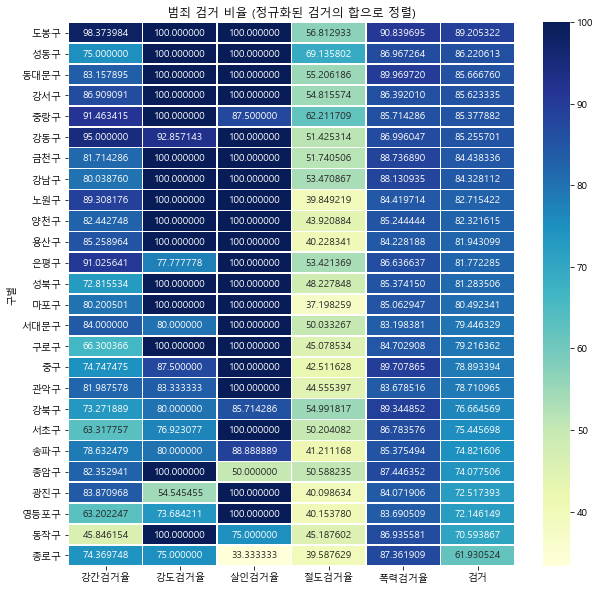

In [220]:
# 검거율 heatmap 
# "검거" 컬럼을 기준으로 정렬 

def crimeCatch():
    
    # 데이터 프레임 생성 
    target_col = ["강간검거율", "강도검거율", "살인검거율", "절도검거율", "폭력검거율", "검거"]
    crime_sort = crime.sort_values(by="검거", ascending=False) # 내림차순 
    
    # 그래프 설정
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        data=crime_sort[target_col],
        annot=True, # 데이터값 표현 
        fmt="f", # d: 정수, f: 실수
        linewidths=0.5, # 간격설정 
        cmap="YlGnBu",
    )
    plt.title("범죄 검거 비율 (정규화된 검거의 합으로 정렬)")
    plt.show()

crimeCatch()

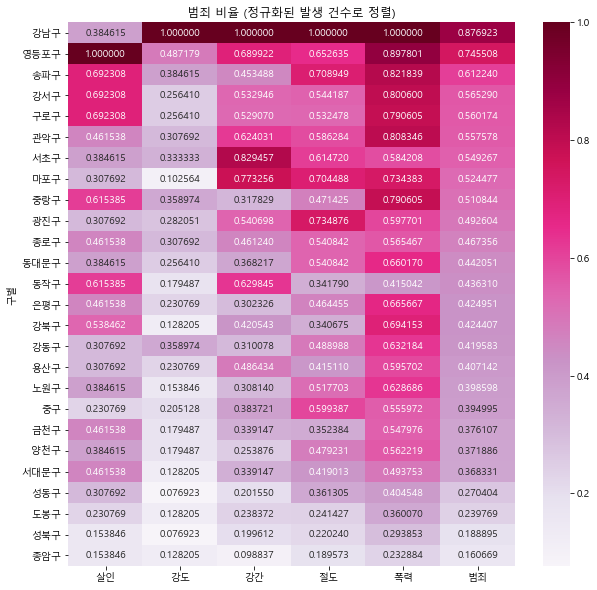

In [221]:
# 범죄발생 건수 heatmap 
# "범죄" 컬럼을 기준으로 정렬 

def crimeOccurs():
    
    # 데이터 프레임 생성 
    target_col = ["살인", "강도", "강간", "절도", "폭력", "범죄"]
    crime_norm_sort = crime_norm.sort_values(by="범죄", ascending=False) # 내림차순 
    
    # 그래프 설정
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        data=crime_norm_sort[target_col],
        annot=True,
        fmt="f",
        cmap="PuRd",
    )
    plt.title("범죄 비율 (정규화된 발생 건수로 정렬)")
    plt.show()

crimeOccurs()

---

## 6. 서울시 범죄현황 데이터 시각화 (지도 시각화 1)

In [203]:
# csv 파일 읽기
crime = pd.read_csv(
    "../data/02. crime_in_Seoul_final.csv", index_col=0, encoding="utf-8"
)

In [205]:
# json 파일에 나온 위도, 경도 데이터를 이용하여 지도 시각화

geo_path = "../data/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

In [206]:
crime.head(1)

,살인,강도,강간,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,0.384615,1.0,1.0,1.0,1.0,80.03876,100.0,100.0,53.470867,88.130935,561052.0,3238.0,0.876923,84.328112


In [224]:
# 서울시에서 어느 구에서 검거가 많이 이루어졌는가?

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles="Stamen Toner")

my_map.choropleth(
    geo_data=geo_str,
    data=crime_norm["검거"],
    columns=[crime_norm.index, crime_norm["검거"]],
    fill_color="YlGnBu",
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="검거율이 높은 구",
)

my_map

In [250]:
# 서울시에서 어느 구에서 범죄가 많이 일어나는가?

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles="Stamen Toner")

my_map.choropleth(
    geo_data=geo_str,
    data=crime_norm["범죄"],
    columns=[crime_norm.index, crime_norm["범죄"]],
    fill_color="PuRd",
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="범죄율이 높은 구",
)

my_map

In [226]:
# 인구 대비 어느 구에서 범죄가 많이 일어나는가?

crime_population = crime_norm["범죄"] / crime_norm["인구수"]

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles="Stamen Toner")

my_map.choropleth(
    geo_data=geo_str,
    data=crime_population,
    columns=[crime_norm.index, crime_population],
    fill_color="PuRd",
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="인구수 대비 범죄율이 높은 구"
)

my_map

---

## 7. 서울시 범죄현황 데이터 시각화 (지도 시각화 1)
- 경찰서별 검거현황과 구별 범죄발생 현황을 표현하기

In [228]:
# 구별 경찰서 데이터
crime_station = pd.read_csv("../data/02. crime_in_Seoul_1st.csv", index_col=0, encoding="utf-8")
crime_station.head()

,구분,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,lat,lng
0,강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,강남구,37.509435,127.066958
1,강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,강동구,37.528511,127.126822
2,강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,강북구,37.637388,127.027324
3,강서,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0,강서구,37.539783,126.829997
4,관악,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0,관악구,37.474379,126.950975


In [229]:
# 검거수를 정규화한 후 검거의 평균을 컬럼으로 생성
col = ["살인검거", "강도검거", "강간검거", "절도검거", "폭력검거"]
catch_norm = crime_station[col] / crime_station[col].max()
crime_station["검거"] = np.mean(catch_norm, axis=1)

crime_station.head()

,구분,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,구별,lat,lng,검거
0,강남,269.0,339.0,26.0,24.0,3.0,3.0,1129.0,2438.0,2096.0,2336.0,강남구,37.509435,127.066958,0.753687
1,강동,152.0,160.0,13.0,14.0,5.0,4.0,902.0,1754.0,2201.0,2530.0,강동구,37.528511,127.126822,0.578102
2,강북,159.0,217.0,4.0,5.0,6.0,7.0,672.0,1222.0,2482.0,2778.0,강북구,37.637388,127.027324,0.506577
3,강서,239.0,275.0,10.0,10.0,10.0,9.0,1070.0,1952.0,2768.0,3204.0,강서구,37.539783,126.829997,0.753796
4,관악,264.0,322.0,10.0,12.0,7.0,6.0,937.0,2103.0,2707.0,3235.0,관악구,37.474379,126.950975,0.695650


In [232]:
# 경찰서 위치를 지도에 표시

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for idx, rows in crime_station.iterrows():
    folium.Marker([rows["lat"], rows["lng"]]).add_to(my_map)
    
my_map

In [236]:
# 검거에 적절한 값을 곱해서 원의 넓이로 사용

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for idx, rows in crime_station.iterrows():
    folium.CircleMarker(
        [rows["lat"], rows["lng"]],
        radius=rows["검거"] * 50,
        popup=rows["구분"] + " : " + "%.2f" % rows["검거"],
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
    ).add_to(my_map)
    
my_map

In [239]:
# 구별 범죄 현황과 경찰서별 검거현황을 함께 표시

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

my_map.choropleth(
    geo_data=geo_str,
    data=crime_norm["범죄"],
    columns=[crime_norm.index, crime_norm["범죄"]],
    fill_color="PuRd",
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=0.2,
)

for idx, rows in crime_station.iterrows():
    folium.CircleMarker(
        [rows["lat"], rows["lng"]],
        radius=rows["검거"] * 50,
        popup=rows["구분"] + " : " + "%.2f" % rows["검거"],
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
    ).add_to(my_map)
    
my_map

---

## 8. 가설
- 강남의 범죄 발생이 많은 것은 혹시 유흥업소의 밀집과 관련이 있지는 않을까

In [243]:
crime_loc_raw = pd.read_csv(
    "../data/02. crime_in_Seoul_location.csv", thousands=",", encoding="euc-kr"
)
crime_loc_raw.head()

,범죄명,장소,발생건수
0,살인,"아파트, 연립 다세대",12
1,살인,단독주택,30
2,살인,노상,22
3,살인,상점,1
4,살인,"숙박업소, 목욕탕",4


In [245]:
# 피봇테이블 & 멀티컬럼 처리
crime_loc = crime_loc_raw.pivot_table(
    crime_loc_raw, index=["장소"], columns=["범죄명"], aggfunc=[np.sum]
)
crime_loc.columns = crime_loc.columns.droplevel([0, 1])
crime_loc.head()

범죄명,강간.추행,강도,살인,절도,폭력
장소,,,,,
교통수단,691,0,0,457,222
금융기관,2,1,1,1081,42
기타,2128,67,65,21734,26382
노상,986,87,22,9329,24535
단독주택,395,15,30,2241,3579


In [246]:
# 정규화
col = ["살인", "강도", "강간", "절도", "폭력"]
crime_loc_norm = crime_loc / crime_loc.max()
crime_loc_norm.head()

범죄명,강간.추행,강도,살인,절도,폭력
장소,,,,,
교통수단,0.324718,0.000000,0.000000,0.021027,0.008415
금융기관,0.000940,0.011494,0.015385,0.049738,0.001592
기타,1.000000,0.770115,1.000000,1.000000,1.000000
노상,0.463346,1.000000,0.338462,0.429235,0.929990
단독주택,0.185620,0.172414,0.461538,0.103110,0.135661


In [247]:
crime_loc_norm["종합"] = np.mean(crime_loc_norm, axis=1)
crime_loc_norm.head()

범죄명,강간.추행,강도,살인,절도,폭력,종합
장소,,,,,,
교통수단,0.324718,0.000000,0.000000,0.021027,0.008415,0.070832
금융기관,0.000940,0.011494,0.015385,0.049738,0.001592,0.015830
기타,1.000000,0.770115,1.000000,1.000000,1.000000,0.954023
노상,0.463346,1.000000,0.338462,0.429235,0.929990,0.632207
단독주택,0.185620,0.172414,0.461538,0.103110,0.135661,0.211669


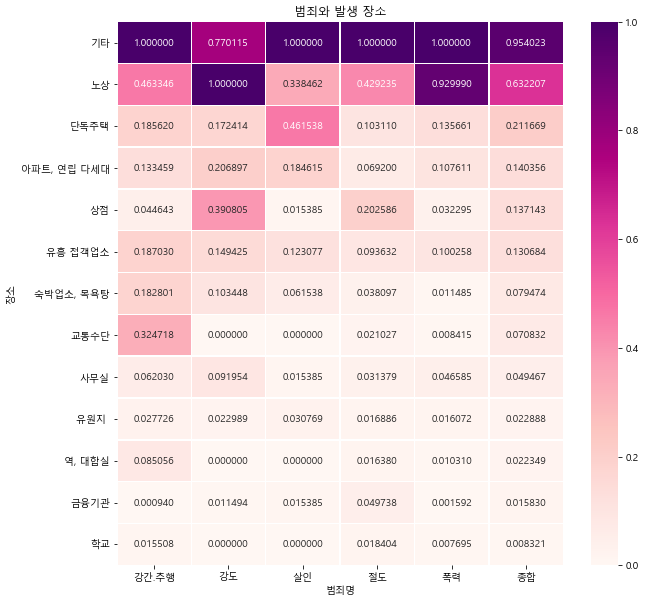

In [249]:
# 가설과는 달리 노상에서 범죄 발생이 많이 일어남
crime_loc_norm_sort = crime_loc_norm.sort_values(by="종합", ascending=False)

def crime_loc():
    plt.figure(figsize=(10, 10))
    sns.heatmap(crime_loc_norm_sort, annot=True, fmt="f", linewidths=0.5, cmap="RdPu")
    plt.title("범죄와 발생 장소")
    plt.show()
    
crime_loc()